In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r'C:\Users\hafid\OneDrive\Desktop\KMDF-GPDriver\Script\[new]registryCSV\registries.csv')

In [3]:
selected_features = [
    'ProcessImageEntropy',
    'SensitiveKeysAccessed',
    'RegistryValueEntropyAvg', 'IS_MALWARE'
]
X = df[selected_features]

In [4]:
X[selected_features].nunique().sort_values()


IS_MALWARE                   2
ProcessImageEntropy         77
RegistryValueEntropyAvg    561
SensitiveKeysAccessed      565
dtype: int64

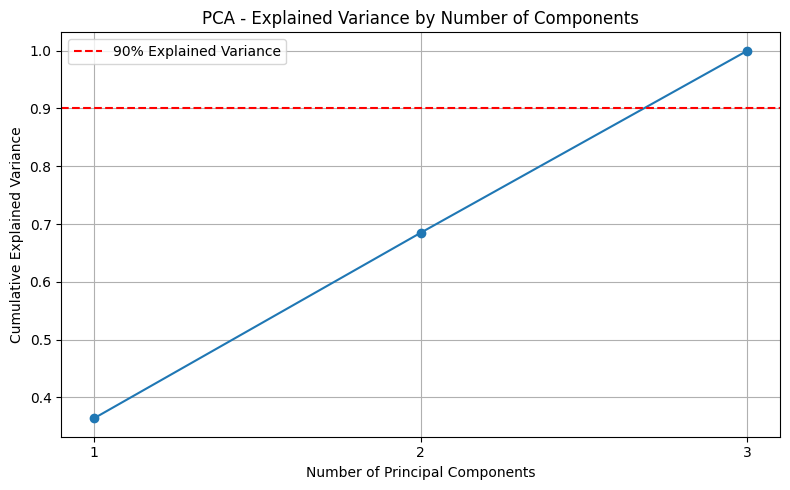

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()
X_cluster = X.drop(columns='IS_MALWARE')
X_scaled = scaler.fit_transform(X_cluster)
pca = PCA().fit(X_scaled)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')  # garis bantu
plt.xticks(range(1, len(cumulative_variance)+1))
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA - Explained Variance by Number of Components')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
pca = PCA(n_components=2)
X_scaled = pca.fit_transform(X_scaled)

In [7]:
# features_to_check = [col for col in selected_features if col != 'IS_MALWARE']

# outlier_mask = pd.Series(False, index=X.index)

# print("=== Deteksi Outlier per Kolom (IQR Method) ===")
# for col in features_to_check:
#     Q1 = X[col].quantile(0.25)
#     Q3 = X[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     col_outliers = (X[col] < lower_bound) | (X[col] > upper_bound)
#     outlier_count = col_outliers.sum()
#     outlier_mask |= col_outliers

#     print(f"Kolom '{col}': {outlier_count} outlier")

# total_outlier_rows = outlier_mask.sum()

# malware_lost = X.loc[outlier_mask, 'IS_MALWARE'].sum()

# print("\n=== Summary ===")
# print(f"Total baris outlier unik (terdampak minimal satu kolom): {total_outlier_rows}")
# print(f"Jumlah data dengan IS_MALWARE = 1 yang akan hilang jika outlier dihapus: {int(malware_lost)}")

In [8]:
from sklearn.ensemble import IsolationForest

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns




model = IsolationForest(contamination=0.05, random_state=42)
y_pred = model.fit_predict(X_scaled)


df['Anomaly'] = y_pred

print(df['Anomaly'].value_counts())

if 'IS_MALWARE' in df.columns:
    from sklearn.metrics import classification_report
    print(classification_report(df['IS_MALWARE'], df['Anomaly'].replace({1: 0, -1: 1})))

Anomaly
 1    188830
-1      9935
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    194574
           1       0.17      0.40      0.24      4191

    accuracy                           0.95    198765
   macro avg       0.58      0.68      0.60    198765
weighted avg       0.97      0.95      0.96    198765



In [9]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)
ocsvm.fit(X_scaled)

y_pred_ocsvm = ocsvm.predict(X_scaled)

df['Anomaly_OCSVM'] = y_pred_ocsvm
print(df['Anomaly_OCSVM'].value_counts())
if 'IS_MALWARE' in df.columns:
    print(classification_report(df['IS_MALWARE'], df['Anomaly_OCSVM'].replace({1: 0, -1: 1})))

Anomaly_OCSVM
 1    189831
-1      8934
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.99      0.97      0.98    194574
           1       0.25      0.54      0.35      4191

    accuracy                           0.96    198765
   macro avg       0.62      0.75      0.66    198765
weighted avg       0.97      0.96      0.96    198765



In [10]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
y_pred_lof = lof.fit_predict(X_scaled)

df['Anomaly_LOF'] = y_pred_lof
print(df['Anomaly_LOF'].value_counts())
if 'IS_MALWARE' in df.columns:
    print(classification_report(df['IS_MALWARE'], df['Anomaly_LOF'].replace({1: 0, -1: 1})))


Anomaly_LOF
 1    189505
-1      9260
Name: count, dtype: int64
              precision    recall  f1-score   support

           0       0.99      0.96      0.98    194574
           1       0.24      0.53      0.33      4191

    accuracy                           0.95    198765
   macro avg       0.61      0.75      0.65    198765
weighted avg       0.97      0.95      0.96    198765



C:\Users\hafid\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
